# Introduction

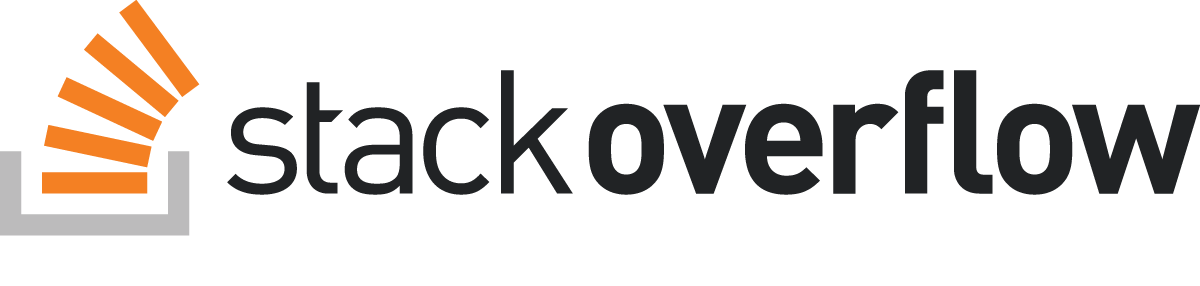

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.
Les données

Stack Overflow propose un outil d’export de données - "stackexchange explorer", qui recense un grand nombre de données authentiques de la plateforme d’entraide. 

**Contraintes:**

* Mettre en œuvre une approche non supervisée.
* Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
* Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
* Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
* Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.


# Sommaire

1. [Extraction des données](#data-extract)  
2. [Analyse exploratoire](#preprocessing)  
    2.1. [Chargement et contrôle des données](#data-load-and-check)  
    2.2. [Analyse des tags](#tags-analyze)   
    2.3. [Analyse du contenu](#content-analyze)  
    &nbsp;&nbsp;&nbsp;&nbsp;2.3.1 [Recherche de tags dans le contenu](#content-tags)  
    &nbsp;&nbsp;&nbsp;&nbsp;2.3.2 [Filtre des mots récurrents](#content-overused-worlds)   
    2.4. [Réduction manuelle](#manual-reduction)   
    2.5. [Variable pondérée](#weighted-var)  
3. [Modélisation sur l'échantillon](#modelization)    
    3.1. [Modélisation naïve](#naive-model)  
    3.2. [Modélisation non supervisée avec LDA](#unsupervised-model)  
    3.3. [Modélisation supervisée](#supervised-model)  

# <a id="data-extract">Extraction des données<a/> 

Nombre de posts conenuts dans la base

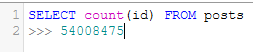

On va donc devoir filtré en gardant les données les plus cohérentes.

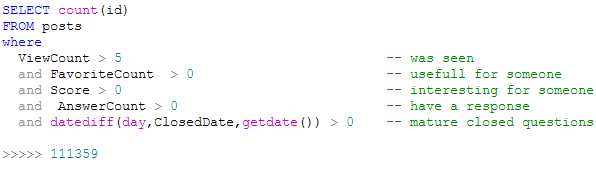

On importe alors les données par tranche limite de 50 000 lignes en se basant sur l'ID de la dernière ligne téléchargée.

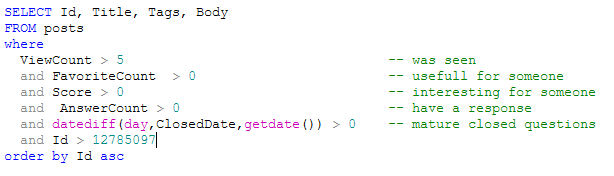

# <a id="preprocessing">Analyse exploratoire<a/> 

##  <a id="data-load-and-check">Chargement et contrôle des données<a/>   

In [1]:
# import libraries

# accelerate sklearn with scikit-learn-intelex  from intel
# from sklearnex import patch_sklearn
# patch_sklearn()

import math
import pandas as pd
import re
import nltk
import scipy
import joblib
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
from pprint import pprint
from bs4 import BeautifulSoup

from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

import functions as fn

In [2]:
# load datas
data_already_filtered = True

# init stop words
sw = set()
sw.update(tuple(nltk.corpus.stopwords.words('english')))
    
# durée de la lemmatisation de 45min, enregistré les résultats permet de gagner du temps
if(data_already_filtered):
    # load filtered data
    df = pd.read_csv('filtered_data.csv')
else:
   
    # load files
    data = []
    for i in range(1,4):
        data.append(pd.read_csv('QueryResults_{}.csv'.format(i)))#, nrows=3000))
    df = pd.concat(data, axis=0, ignore_index=True)
    
    # remove html and xml tags
    display(df.iloc[0])
    df['Body'] = df['Body'].apply(lambda text: BeautifulSoup(text, 'html.parser').get_text())
    df['Tags'] = df['Tags'].str.replace('<', '')
    df['Tags'] = df['Tags'].str.replace('>', ' ')
    
    # apply filter fonction
    df['BodyFiltered'] = df['Body'].apply(lambda x : fn.filter_content(x,sw))
    df['TitleFiltered'] = df['Title'].apply(lambda x : fn.filter_content(x,sw))
    
    # save data
    df.to_csv('filtered_data.csv', columns = ['Tags','BodyFiltered','TitleFiltered'], index=False)
    
display(df)

Tags  \
0            mysql database binary-data data-storage    
1                         php sql database flat-file    
2       svn tortoisesvn branch branching-and-merging    
3                                 windows svn 64-bit    
4                       java xml csv data-conversion    
...                                               ...   
110640                            javascript cookies    
110641                 c++ c linked-list clang stm32    
110642                    github pull-request review    
110643                                   python uuid    
110644                                javascript css    

                                             BodyFiltered  \
0                           store binary datum mysql ? \n   
1       good practice around create flat file database...   
2       branch merge apache subversion use tortoisesvn...   
3       use tortoisesvn   windows environment quite ti...   
4       exist application library java allow convert c...   
...                                                   ...   
110640  find chrome extension able access edit http - ...   
110641  let say function , b , & c. \n would like writ...   
110642  github review change pull request leave commen...   
110643  want create function add - position 8 , 12 , 1...   
110644  want display text low - quality image backgrou...   

                                            TitleFiltered  \
0                                       binary data mysql   
1                                      flat file database   
2                              branch merge tortoisesvn ?   
3          best subversion client windows vista ( 64bit )   
4                     java lib app convert csv xml file ?   
...                                                   ...   
110640       people access http - cookie via javascript ?   
110641                     write function link function c   
110642  author reviewer " resolve conversation " comme...   
110643                        insert hyphen uuid string ?   
110644              make jagged text use css / javascript   

                                                  Content  \
0         binary data mysql store binary datum mysql ? \n   
1       flat file database good practice around create...   
2       branch merge tortoisesvn ? branch merge apache...   
3       best subversion client windows vista ( 64bit )...   
4       java lib app convert csv xml file ? exist appl...   
...                                                   ...   
110640  people access http - cookie via javascript ? f...   
110641  write function link function c let say functio...   
110642  author reviewer " resolve conversation " comme...   
110643  insert hyphen uuid string ? want create functi...   
110644  make jagged text use css / javascript want dis...   

                                            ContainedTags  \
0                         binary mysql store binary mysql   
1       flat file database flat file database structur...   
2       branch merge tortoisesvn branch merge apache t...   
3       client windows bit tortoisesvn windows environ...   
4       java lib csv xml file java csv file xml file x...   
...                                                   ...   
110640  http javascript find edit http http javascript...   
110641  function function c let function b c function ...   
110642    author github review pull request author button   
110643  insert hyphen uuid string function add positio...   
110644  text css javascript display text image backgro...   

                                          WeightedContent  \
0       binary data mysql binary data mysql binary dat...   
1       flat file database flat file database flat fil...   
2       branch merge tortoisesvn ? branch merge tortoi...   
3       best subversion client windows vista ( 64bit )...   
4       java lib app convert csv xml file ? java lib a...   
...                                                   ...   
11064

##  <a id="tags-analyze">Analyse des tags<a/>   

In [3]:
if data_already_filtered: 
    # load analyzed tags count
    df_tag_count = pd.read_csv('known-tags-count.csv')
else:
    tags_tokenized = []
    for tags in df['Tags']:
        tags_tokenized.append(fn.tokenize(tags))
    stats, freq = dict(), dict()
    i=0
    for tags in tags_tokenized:
        freq[i] = fq = nltk.FreqDist(tags)
        stats[i] = {'total': len(tags), 'unique': len(fq.keys())}
        i += 1
    df_tag_count = df['Tags'].str.split(expand=True).stack().value_counts().to_frame()
    df_tag_count.reset_index(level=0, inplace=True)
    df_tag_count.columns = ['tag','count']
    df_tag_count['cumSum'] = df_tag_count['count'].cumsum()
    tag_count = df_tag_count['count'].sum()
    df_tag_count['cumSumPerCent']=df_tag_count['cumSum']*100/tag_count
    df_tag_count.reset_index()
    df_tag_count['indexPerCent']=(df_tag_count.index +1)*100/(df_tag_count.shape[0])
    # on enregistre la tables des tags connus
    df_tag_count.to_csv('known-tags-count.csv', index=False)
    
display(df_tag_count)

tag  count  cumSum  cumSumPerCent  indexPerCent
0                   java  13986   13986       4.382403      0.006293
1             javascript  10820   24806       7.772764      0.012587
2                 python   9819   34625      10.849470      0.018880
3                     c#   9181   43806      13.726264      0.025173
4                    c++   7179   50985      15.975747      0.031466
...                  ...    ...     ...            ...           ...
15885     sessionfactory      1  319136      99.998747     99.974827
15886        netbeans6.8      1  319137      99.999060     99.981120
15887          wsdl2java      1  319138      99.999373     99.987413
15888  execute-immediate      1  319139      99.999687     99.993707
15889       uno-platform      1  319140     100.000000    100.000000

[15890 rows x 5 columns]

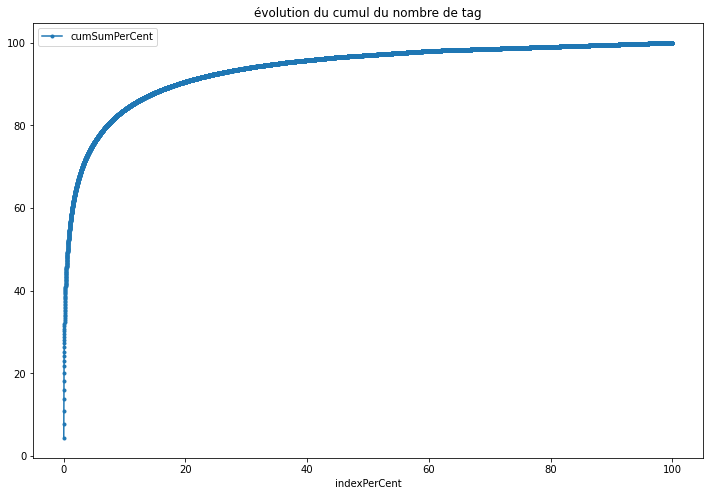

In [4]:

df_tag_count.plot(x='indexPerCent', y='cumSumPerCent', marker='.', figsize=(12, 8))
plt.title('évolution du cumul du nombre de tag')
plt.show()

7% des tags explique 80% des questions on va donc pouvoir réaliser un filtre sur les tags ce qui équivaudra pour la suite à une première réduction de la dimension du problème quand il sera tokenizé en gardant uniquement les tags de poids fort. 

In [5]:
df_tag_count['countCategory'] =  df_tag_count['count'].apply(fn.tag_count_slice)

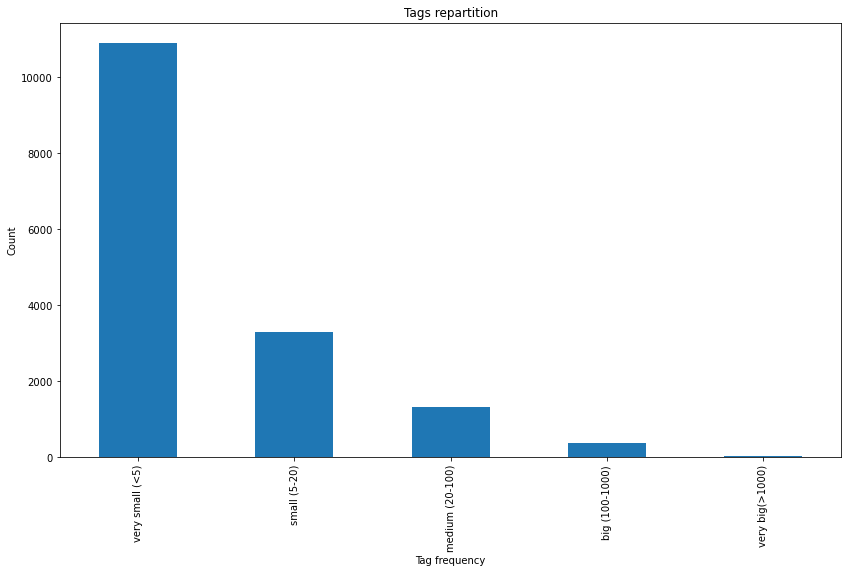

In [6]:
ax = df_tag_count['countCategory'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Tags repartition")
ax.set_xlabel("Tag frequency")
ax.set_ylabel("Count")
plt.show()

##  <a id="content-analyze">Analyse du contenu<a/>   

###  <a id="content-tags">Recherche de tags dans le contenu<a/>   

In [7]:
tags = df_tag_count['tag'].values

if(not data_already_filtered):
    df['Content'] = df['TitleFiltered'] + ' ' + df['BodyFiltered']
    # filtre très long à appliquer (30min) donc on enregistre les résultats
    df['ContainedTags'] =  df['Content'].apply(lambda x: fn.filtered_by_tags(x, tags))
    df.to_csv('filtered_data.csv', index=False)
    
display(df[['Tags', 'ContainedTags']])

Tags  \
0            mysql database binary-data data-storage    
1                         php sql database flat-file    
2       svn tortoisesvn branch branching-and-merging    
3                                 windows svn 64-bit    
4                       java xml csv data-conversion    
...                                               ...   
110640                            javascript cookies    
110641                 c++ c linked-list clang stm32    
110642                    github pull-request review    
110643                                   python uuid    
110644                                javascript css    

                                            ContainedTags  
0                         binary mysql store binary mysql  
1       flat file database flat file database structur...  
2       branch merge tortoisesvn branch merge apache t...  
3       client windows bit tortoisesvn windows environ...  
4       java lib csv xml file java csv file xml file x...  
...                                                   ...  
110640  http javascript find edit http http javascript...  
110641  function function c let function b c function ...  
110642    author github review pull request author button  
110643  insert hyphen uuid string function add positio...  
110644  text css javascript display text image backgro...  

[110645 rows x 2 columns]

Cette approche pourra nous servir à réaliser une analyse naïve du problème en comptant simplement les tags existant présent dans le contenu des questions.

###  <a id="content-overused-worlds">Filtrer les mots récurrents<a/>   

In [8]:
if data_already_filtered:
    # load analyzed words count
    df_words_count = pd.read_csv('content-words-count.csv')
else:
    content_words_tokenized = []
    for content in df['Content'].values:
        content_words_tokenized.append(fn.tokenize(content.lower()))
    #display(content_words_tokenized)
    freq = dict()
    i=0
    for words in content_words_tokenized:
        freq[i] = fq = nltk.FreqDist(words)
        i += 1 
    # on récupère la fréquence totale de chaque tag
    freq_words = nltk.Counter()
    for i in range(0,len(content_words_tokenized)):
        freq_words += freq[i]
    #for item, count in freq_words.most_common():
    #    print ('{} -> {}'.format(item,count))
    words_count = []
    for item, count in freq_words.most_common():
        words_count.append([ item, count])
    df_words_count = pd.DataFrame(data=words_count, columns=["words", "count"])
    df_words_count.to_csv('content-words-count.csv', index=False)

#display(df_words_count)
display(df_words_count)

words   count
0                    use  105730
1                   code   50968
2                   like   49619
3                   file   48808
4                    get   48052
...                  ...     ...
215265      holosericeus       1
215266        agelaioide       1
215267  programattically       1
215268              d422       1
215269              cb93       1

[215270 rows x 2 columns]

In [9]:
max_tag_count = df_tag_count['count'].max()
unrepresentative_worlds = []
limit = max_tag_count/3
unrepresentative_worlds = df_words_count[df_words_count['count']>limit]['words'].values
sw.update(unrepresentative_worlds)

print(sw)
df_stop_words = pd.DataFrame(data=sw, columns=["stop-words"])
df_stop_words.to_csv('stop-words.csv', index=False)
display(df_stop_words)

{'some', nan, 'not', 'node', 'run', 'set', 'tool', 'result', 'her', 'shan', 'character', 'loop', 'well', 'or', 'key', 'such', 'know', 'program', 'type', 'shouldn', 're', "you're", 'load', 'version', 'does', 'public', 'output', 'two', 'weren', 'i', 'client', 'value', 'false', 'for', 'fail', 'generate', 'sure', 'to', 'line', 'static', 'size', 'in', 'integer', 'address', 'my', 'a', 'again', 'we', 'herself', 'long', 'convert', 'second', 'because', 'about', "needn't", 'has', 'understand', 'll', 'had', 'form', "that'll", 'https', 'new', 'parameter', 'memory', "didn't", 'first', 'many', 'sql', 'compile', 'xml', 'feature', 'then', 'since', 'software', 'get', 'have', 'div', 'response', 'didn', 'itself', 'color', 'define', 'x', 'table', 'text', 'change', 'allow', 'at', 'doing', 'good', 'too', 'but', '.js', 'm', 'app', 'template', 'down', 'follow', 'implement', 'view', 'him', 'connection', 'state', 'myself', 'wonder', 'element', "isn't", 'string', 'put', 'make', 'com', 'f', 'thing', 'interface', 

stop-words
0         some
1          NaN
2          not
3         node
4          run
..         ...
504        don
505        org
506         as
507     wouldn
508        log

[509 rows x 1 columns]

## <a id="manual-reduction">Réduction manuelle<a/>   

In [10]:
minor_tags = df_tag_count[df_tag_count['cumSumPerCent']>85]['tag'].values
major_tags = df_tag_count[df_tag_count['cumSumPerCent']<85]['tag'].values

array(['getelementbyid', 'nsuserdefaults', 'highcharts', ..., 'wsdl2java',
       'execute-immediate', 'uno-platform'], dtype=object)

14109


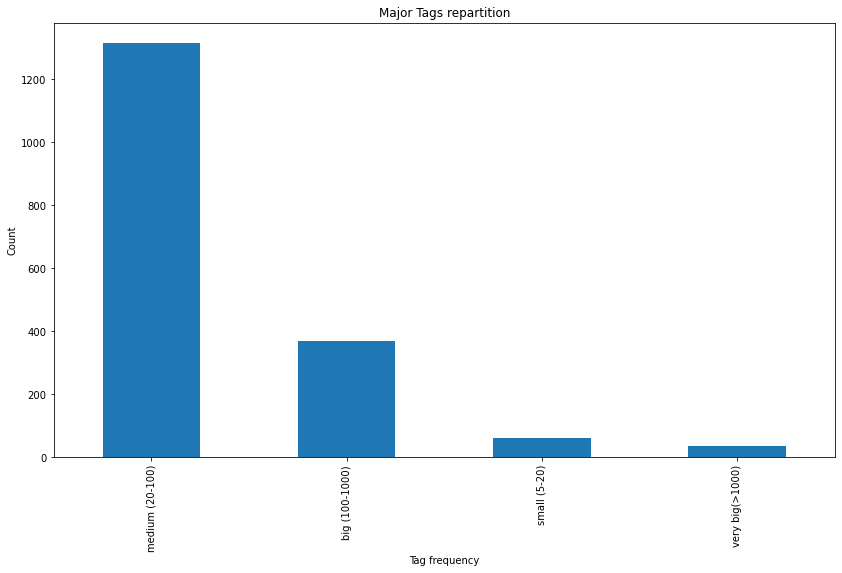

In [12]:
ax = df_tag_count[df_tag_count['cumSumPerCent']<85]['countCategory'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Major Tags repartition")
ax.set_xlabel("Tag frequency")
ax.set_ylabel("Count")
plt.show()

Les tags étant mélangé, garder les lignes contenant un tag major (présent dans plus de 90% des questions) équivaut à garder quasiment toutes les lignes (on retire 200 lignes sur plus de 110 000). On va par conséquent chercher à filtrer les lignes contenant des tags mineur ce qui équivaut à garder à peu près 7% des données ce qui nous permettra de traiter les données assez rapidement en gardant un fort impact contextuel. En effet, nous aurons ainsi extrait les données le splus représentatives et les plus stables.

In [13]:
safe_minor_tags = [re.escape(m) for m in minor_tags]
#display(safe_major_tags)
# on filtre le dataframe de données pour ne garder que les lignes contenant des tags majeurs
display(df.shape)
df_major = df[~df['Tags'].str.contains('|'.join(safe_minor_tags))]
display(df_major.shape)
display(df_major)

(110645, 10)

(7651, 10)

Tags                                       BodyFiltered  \
16              c++ regex   look robust , easy - - use , regular expressio...   
38                c# .net   actually difference two cast ? \n someclass sc...   
48      php c++ linux ide   even though robust fast computer ( pentium dua...   
76                 openid   one openid try numerous .   people take openid...   
79                  regex   really understand regular expression .   expla...   
...                    ...                                                ...   
110606       flutter dart   upgrade late version flutter , get deprecation...   
110615              linux   run pop os 20.04 & instal / uninstalled vs cod...   
110623                git   accidentally make ( 20 ) commit local , unpush...   
110629                php   learn php . two variable like \n $ user_name =...   
110633                c++   try use lambda define class member .   pretty ...   

                                            TitleFiltered  \
16          easy - - use regular expression support c++ ?   
38                  cast : ( newtype ) vs. object newtype   
48                                  lightweight ide linux   
76                                       use one openid ?   
79                               learn regular expression   
...                                                   ...   
110606                         flutter : list deprecate ?   
110615  vs code n : skip acquire configure file   main...   
110623                   reauthor commit git repository ?   
110629                 use php variable inside php string   
110633         use lamda define member variable class cpp   

                                                  Content  \
16      easy - - use regular expression support c++ ? ...   
38      cast : ( newtype ) vs. object newtype actually...   
48      lightweight ide linux even though robust fast ...   
76      use one openid ? one openid try numerous .   p...   
79      learn regular expression really understand reg...   
...                                                   ...   
110606  flutter : list deprecate ? upgrade late versio...   
110615  vs code n : skip acquire configure file   main...   
110623  reauthor commit git repository ? accidentally ...   
110629  use php variable inside php string learn php ....   
110633  use lamda define member variable class cpp try...   

                                            ContainedTags  \
16      expression c++ expression native c++ platform ...   
38             newtype object newtype difference explicit   
48      ide linux core ram search migrate linux free i...   
76      openid openid take openid supplier go email st...   
79                                  expression expression   
...                                                   ...   
110606  flutter list upgrade version flutter get list ...   
110615  skip configure file main binary package sudo a...   
110623  commit git repository commit local git reposit...   
110629  php php string php abc curl string require ema...   
110633  member class lambda class member neat get obje...   

                                          WeightedContent  \
16      easy - - use regular expression support c++ ? ...   
38      cast : ( newtype ) vs. object newtype cast : (...   
48      lightweight ide linux lightweight ide linux li...   
76      use one openid ? use one openid ? use one open...   
79      learn regular expression learn regular express...   
...                                                   ...   
110606  flutter : list deprecate ? flutter : list depr...   
110615  vs code n : skip acquire configure file   main...   
110623  reauthor commit git repository ? reauthor comm...   
110629  use php variable inside php string use php var...   
110633  use lamda define member variable class cpp use...   

                                       ContainedMajorTags  \
16      expression c++ expression native c++ platform ..

Cette approche nous laisse néanmoins 1784 tags major ce qui risque d'être encore trop pour une approche supervisée faites avec un simple ordinateur de bureau. Nous allons donc générer une deuxième dataframe de données mais encore plus allégée au niveau du nombre de tag. Nous allons essayer de garder une centaine de tags max.

In [14]:
display(df_tag_count.iloc[100])
ultra_major_tags = df_tag_count[df_tag_count['cumSumPerCent']<50]['tag'].values
ultra_minor_tags = df_tag_count[df_tag_count['cumSumPerCent']>50]['tag'].values
display(len(ultra_major_tags))
display(len(ultra_minor_tags))
ultra_safe_minor_tags = [re.escape(str(m)) for m in ultra_minor_tags]
df_ultra_major = df[~df['Tags'].str.contains('|'.join(ultra_safe_minor_tags))]
display(df_ultra_major)

tag                   templates
count                       377
cumSum                   158406
cumSumPerCent          49.63527
indexPerCent            0.63562
countCategory    big (100-1000)
Name: 100, dtype: object

104

15786

Tags                                       BodyFiltered  \
16      c++ regex   look robust , easy - - use , regular expressio...   
38        c# .net   actually difference two cast ? \n someclass sc...   
79          regex   really understand regular expression .   expla...   
103           oop   since start study object - orient programming ...   
137           wpf   well , get nice wpf book call sams windows pre...   
...            ...                                                ...   
110584         c#   quite new programming use c # . experience sim...   
110615      linux   run pop os 20.04 & instal / uninstalled vs cod...   
110623        git   accidentally make ( 20 ) commit local , unpush...   
110629        php   learn php . two variable like \n $ user_name =...   
110633        c++   try use lambda define class member .   pretty ...   

                                            TitleFiltered  \
16          easy - - use regular expression support c++ ?   
38                  cast : ( newtype ) vs. object newtype   
79                               learn regular expression   
103                                       oop well suit ?   
137                            wpf book would recommend ?   
...                                                   ...   
110584                           c # strings method empty   
110615  vs code n : skip acquire configure file   main...   
110623                   reauthor commit git repository ?   
110629                 use php variable inside php string   
110633         use lamda define member variable class cpp   

                                                  Content  \
16      easy - - use regular expression support c++ ? ...   
38      cast : ( newtype ) vs. object newtype actually...   
79      learn regular expression really understand reg...   
103     oop well suit ? since start study object - ori...   
137     wpf book would recommend ? well , get nice wpf...   
...                                                   ...   
110584  c # strings method empty quite new programming...   
110615  vs code n : skip acquire configure file   main...   
110623  reauthor commit git repository ? accidentally ...   
110629  use php variable inside php string learn php ....   
110633  use lamda define member variable class cpp try...   

                                            ContainedTags  \
16      expression c++ expression native c++ platform ...   
38             newtype object newtype difference explicit   
79                                  expression expression   
103          oop object article function model object oop   
137     wpf get nice wpf call windows presentation fou...   
...                                                   ...   
110584  c c vba autodesk editor call string fill apply...   
110615  skip configure file main binary package sudo a...   
110623  commit git repository commit local git reposit...   
110629  php php string php abc curl string require ema...   
110633  member class lambda class member neat get obje...   

                                          WeightedContent  \
16      easy - - use regular expression support c++ ? ...   
38      cast : ( newtype ) vs. object newtype cast : (...   
79      learn regular expression learn regular express...   
103     oop well suit ? oop well suit ? oop well suit ...   
137     wpf book would recommend ? wpf book would reco...   
...                                                   ...   
110584  c # strings method empty c # strings method em...   
110615  vs code n : skip acquire configure file   main...   
110623  reauthor commit git repository ? reauthor comm...   
110629  use php variable inside php string use php var...   
110633  use lamda define member variable class cpp use...   

                                       ContainedMajorTags  \
16      expression c++ expression native c++ platform ...   
38                                      object difference   
79                    

In [15]:
if(not data_already_filtered):
    # filtre long à appliquer donc on enregistre les résultats
    df['ContainedMajorTags'] =  df['ContainedTags'].apply(lambda x: fn.filtered_major_tags(x, major_tags))
    df['ContainedUltraMajorTags'] =  df['ContainedTags'].apply(lambda x: fn.filtered_major_tags(x, ultra_major_tags))
    df.to_csv('filtered_data.csv', index=False)

display(df[['Tags', 'ContainedUltraMajorTags', 'ContainedMajorTags', 'ContainedTags']])

Tags  \
0            mysql database binary-data data-storage    
1                         php sql database flat-file    
2       svn tortoisesvn branch branching-and-merging    
3                                 windows svn 64-bit    
4                       java xml csv data-conversion    
...                                               ...   
110640                            javascript cookies    
110641                 c++ c linked-list clang stm32    
110642                    github pull-request review    
110643                                   python uuid    
110644                                javascript css    

                                  ContainedUltraMajorTags  \
0                                             mysql mysql   
1       file database file database php php file sql d...   
2                                                     NaN   
3       windows windows windows shell windows windows ...   
4                    java xml file java file xml file xml   
...                                                   ...   
110640                              javascript javascript   
110641  function function c function c function c list...   
110642                                             github   
110643                    string function string c string   
110644                css javascript image css javascript   

                                       ContainedMajorTags  \
0                               binary mysql binary mysql   
1       file database file database structure php php ...   
2       branch merge tortoisesvn branch merge apache t...   
3       client windows bit tortoisesvn windows environ...   
4            java csv xml file java csv file xml file xml   
...                                                   ...   
110640  http javascript find http http javascript call...   
110641  function function c function c function linker...   
110642                              github request button   
110643  insert uuid string function position uuid stri...   
110644  text css javascript text image background text...   

                                            ContainedTags  
0                         binary mysql store binary mysql  
1       flat file database flat file database structur...  
2       branch merge tortoisesvn branch merge apache t...  
3       client windows bit tortoisesvn windows environ...  
4       java lib csv xml file java csv file xml file x...  
...                                                   ...  
110640  http javascript find edit http http javascript...  
110641  function function c let function b c function ...  
110642    author github review pull request author button  
110643  insert hyphen uuid string function add positio...  
110644  text css javascript display text image backgro...  

[110645 rows x 4 columns]

##  <a id="weighted-var">Variable pondérée<a/>   

J'ajoute une colonne qui va pondéré le titre des questions et l'ajouter à notre contenu. Cela aura peut-être un impact mélioratif sur nos algorithmes.

In [16]:
df['WeightedContent'] = 2 * (df['TitleFiltered']+' ') + df['Content']
display(df)

Tags  \
0            mysql database binary-data data-storage    
1                         php sql database flat-file    
2       svn tortoisesvn branch branching-and-merging    
3                                 windows svn 64-bit    
4                       java xml csv data-conversion    
...                                               ...   
110640                            javascript cookies    
110641                 c++ c linked-list clang stm32    
110642                    github pull-request review    
110643                                   python uuid    
110644                                javascript css    

                                             BodyFiltered  \
0                           store binary datum mysql ? \n   
1       good practice around create flat file database...   
2       branch merge apache subversion use tortoisesvn...   
3       use tortoisesvn   windows environment quite ti...   
4       exist application library java allow convert c...   
...                                                   ...   
110640  find chrome extension able access edit http - ...   
110641  let say function , b , & c. \n would like writ...   
110642  github review change pull request leave commen...   
110643  want create function add - position 8 , 12 , 1...   
110644  want display text low - quality image backgrou...   

                                            TitleFiltered  \
0                                       binary data mysql   
1                                      flat file database   
2                              branch merge tortoisesvn ?   
3          best subversion client windows vista ( 64bit )   
4                     java lib app convert csv xml file ?   
...                                                   ...   
110640       people access http - cookie via javascript ?   
110641                     write function link function c   
110642  author reviewer " resolve conversation " comme...   
110643                        insert hyphen uuid string ?   
110644              make jagged text use css / javascript   

                                                  Content  \
0         binary data mysql store binary datum mysql ? \n   
1       flat file database good practice around create...   
2       branch merge tortoisesvn ? branch merge apache...   
3       best subversion client windows vista ( 64bit )...   
4       java lib app convert csv xml file ? exist appl...   
...                                                   ...   
110640  people access http - cookie via javascript ? f...   
110641  write function link function c let say functio...   
110642  author reviewer " resolve conversation " comme...   
110643  insert hyphen uuid string ? want create functi...   
110644  make jagged text use css / javascript want dis...   

                                            ContainedTags  \
0                         binary mysql store binary mysql   
1       flat file database flat file database structur...   
2       branch merge tortoisesvn branch merge apache t...   
3       client windows bit tortoisesvn windows environ...   
4       java lib csv xml file java csv file xml file x...   
...                                                   ...   
110640  http javascript find edit http http javascript...   
110641  function function c let function b c function ...   
110642    author github review pull request author button   
110643  insert hyphen uuid string function add positio...   
110644  text css javascript display text image backgro...   

                                          WeightedContent  \
0       binary data mysql binary data mysql binary dat...   
1       flat file database flat file database flat fil...   
2       branch merge tortoisesvn ? branch merge tortoi...   
3       best subversion client windows vista ( 64bit )...   
4       java lib app convert csv xml file ? java lib a...   
...                                                   ...   
11064

In [17]:
if(not data_already_filtered):
    df['Content'] = df['TitleFiltered'] + ' ' + df['BodyFiltered']
    # filtre très long à appliquer (30min) donc on enregistre les résultats
    df['WeightedContainedTags'] =  df['WeightedContent'].apply(lambda x: fn.filtered_by_tags(x, tags))
    df.to_csv('filtered_data.csv', index=False)
    
display(df[['Tags', 'WeightedContainedTags']])

Tags  \
0            mysql database binary-data data-storage    
1                         php sql database flat-file    
2       svn tortoisesvn branch branching-and-merging    
3                                 windows svn 64-bit    
4                       java xml csv data-conversion    
...                                               ...   
110640                            javascript cookies    
110641                 c++ c linked-list clang stm32    
110642                    github pull-request review    
110643                                   python uuid    
110644                                javascript css    

                                    WeightedContainedTags  
0       binary mysql binary mysql binary mysql store b...  
1       flat file database flat file database flat fil...  
2       branch merge tortoisesvn branch merge tortoise...  
3       client windows bit client windows bit client w...  
4       java lib csv xml file java lib csv xml file ja...  
...                                                   ...  
110640  http javascript http javascript http javascrip...  
110641  function function c function function c functi...  
110642  author author author github review pull reques...  
110643  insert hyphen uuid string insert hyphen uuid s...  
110644  text css javascript text css javascript text c...  

[110645 rows x 2 columns]

In [18]:
if(not data_already_filtered):
    # filtre long à appliquer donc on enregistre les résultats
    df['WeightedContainedMajorTags'] =  df['WeightedContainedTags'].apply(lambda x: fn.filtered_major_tags(x, major_tags))
    df.to_csv('filtered_data.csv', index=False)
    
display(df[['Tags', 'WeightedContainedMajorTags', 'WeightedContainedTags']])

Tags  \
0            mysql database binary-data data-storage    
1                         php sql database flat-file    
2       svn tortoisesvn branch branching-and-merging    
3                                 windows svn 64-bit    
4                       java xml csv data-conversion    
...                                               ...   
110640                            javascript cookies    
110641                 c++ c linked-list clang stm32    
110642                    github pull-request review    
110643                                   python uuid    
110644                                javascript css    

                               WeightedContainedMajorTags  \
0       binary mysql binary mysql binary mysql binary ...   
1       file database file database file database file...   
2       branch merge tortoisesvn branch merge tortoise...   
3       client windows bit client windows bit client w...   
4       java csv xml file java csv xml file java csv x...   
...                                                   ...   
110640  http javascript http javascript http javascrip...   
110641  function function c function function c functi...   
110642                              github request button   
110643  insert uuid string insert uuid string insert u...   
110644  text css javascript text css javascript text c...   

                                    WeightedContainedTags  
0       binary mysql binary mysql binary mysql store b...  
1       flat file database flat file database flat fil...  
2       branch merge tortoisesvn branch merge tortoise...  
3       client windows bit client windows bit client w...  
4       java lib csv xml file java lib csv xml file ja...  
...                                                   ...  
110640  http javascript http javascript http javascrip...  
110641  function function c function function c functi...  
110642  author author author github review pull reques...  
110643  insert hyphen uuid string insert hyphen uuid s...  
110644  text css javascript text css javascript text c...  

[110645 rows x 3 columns]

# <a id="modelization">Modélisation sur l'échantillon<a/> 

##  <a id="naive-model">Modélisation naïve<a/>   

**définition manuelle pour scorer les tag:**  
on note la fréquence d'apparition du tag dans la question et on additionne une note de 1 à 4 en fonction de l'importance du tag dans le corpus définit par les catégories déjà crées on pourra ainsi classé les tag par ordre d'importance et sélectionner ceux dont la note est > 5.

In [19]:
if not data_already_filtered:
    # print(fn.order_words_by_count(df_major['ContainedTags'].values[0]))
    df_major['NaiveEstimatedTags'] = df_major['ContainedMajorTags'].apply(fn.order_words_by_count)
    #display(df_major[['Tags', 'NaiveEstimatedTags', 'ContainedTags' ]])
    df_major['BestNaiveEstimatedTags'] = df_major['NaiveEstimatedTags'].apply(lambda x : fn.score_tags(x,df_tag_count))
    display(df_major[['Tags', 'BestNaiveEstimatedTags', 'NaiveEstimatedTags', 'ContainedTags' ]].head(50))
    df_major['BestNaiveEstimatedTagsScore']  = df_major['Tags'].combine(df_major['BestNaiveEstimatedTags'], func=fn.tags_scoring)
    #display(df_major[['Tags', 'BestNaiveEstimatedTags', 'BestNaiveEstimatedTagsScore' ]].head(50))
    df_major.to_csv('df_major.csv', index=False)
else:
    df_major = pd.read_csv('df_major.csv')
print('Moyenne final de détection des tags de la méthode naïve: {}'.format(df_major['BestNaiveEstimatedTagsScore' ].mean()))

Moyenne final de détection des tags de la méthode naïve: 57.84951858144896


Essayons la même méthode avec les tags major ultra filtrés (la centaine de tag).

In [20]:
if not data_already_filtered:
    df_ultra_major['NaiveEstimatedUltraTags'] = df_ultra_major['ContainedUltraMajorTags'].apply(fn.order_words_by_count)
    df_ultra_major['BestNaiveEstimatedUltraTags'] = df_ultra_major['NaiveEstimatedUltraTags'].apply(lambda x : fn.score_tags(x,df_tag_count))
    display(df_ultra_major[['Tags', 'BestNaiveEstimatedUltraTags', 'ContainedTags' ]].head(50))
    df_ultra_major['BestNaiveEstimatedUltraTagsScore']  = df_ultra_major['Tags'].combine(df_ultra_major['BestNaiveEstimatedUltraTags'], 
                                                                                         func=fn.tags_scoring)
    df_ultra_major.to_csv('df_ultra_major.csv', index=False)
else:
    df_ultra_major = pd.read_csv('df_ultra_major.csv')
print('Moyenne final de détection des tags de la méthode naïve: {}'.format(df_ultra_major['BestNaiveEstimatedUltraTagsScore' ].mean()))

Moyenne final de détection des tags de la méthode naïve: 60.680548355509465


On gagne en précision mais parfois nous avons un retour vide.

In [21]:
if not data_already_filtered:
    df_ultra_major['NaiveEstimatedTags'] = df_ultra_major['ContainedTags'].apply(fn.order_words_by_count)
    df_ultra_major['BestNaiveEstimatedTags'] = df_ultra_major['NaiveEstimatedTags'].apply(lambda x : fn.score_tags(x,df_tag_count))
    display(df_ultra_major[['Tags', 'BestNaiveEstimatedTags', 'ContainedTags' ]].head(50))
    df_ultra_major['BestNaiveEstimatedTagsScore']  = df_ultra_major['Tags'].combine(df_ultra_major['BestNaiveEstimatedTags'], func=fn.tags_scoring)
    df_ultra_major.to_csv('df_ultra_major.csv', index=False)
else:
    df_ultra_major = pd.read_csv('df_ultra_major.csv')
print('Moyenne final de détection des tags de la méthode naïve: {}'.format(df_ultra_major['BestNaiveEstimatedTagsScore' ].mean()))

Moyenne final de détection des tags de la méthode naïve: 58.664535453026886


On perd un petit peu en précision en utilisant le retour de tous les tags existant plutôt que celui des ultratag dont on sait que les tags finaux seront forcément dans ces valeurs, néanmoins cela permet de retourner des valeurs équivalentes quand le tags n'est pas contenu dans le corps du texte. Il me semble donc préférable de priviligier cette méthode.

On peut maintenant créer une fonction de prédiction des tags qui prend en entrée un texte qui sera la représentation d'une contenu d'une question:

In [22]:
# Predict the topic
mytext = """easy - - use regular expression support c++ ? look robust , easy - - use , regular expression evaluator native c++ , either platform - independent windows - specific . 
 requirement : 

 use boost ace regex library ( unfortunately ) 
 use .net regex ( manage code ) 

 main requirement standalone open . """

mytext_predicted_tags = fn.predict_with_naive(mytext, df_tag_count)
print(mytext_predicted_tags)

c++ regex expression


##  <a id="unsupervised-model">Modélisation non supervisée avec LDA<a/>   

On va travailler avec les données ultrafiltrées pour accélérer le traitement des opérations et limiter le nombre de topics à déterminer.

In [23]:
countvectorizer = CountVectorizer(max_df=0.95, min_df=2, tokenizer=fn.tokenize, max_features=100, analyzer='word')
cv_Content = countvectorizer.fit_transform(df_ultra_major['WeightedContent'].values)

In [24]:
n_tags = 100

# Créer le modèle LDA
lda = LatentDirichletAllocation(
    n_components=n_tags, 
    max_iter=50, 
    learning_method='online', 
    random_state=12, 
    batch_size=250, 
    learning_offset=50.,
    evaluate_every = -1,
    n_jobs = -1, )

# Fitter sur les données
lda_output = lda.fit_transform(cv_Content)

performances:

In [25]:
# Log Likelyhood: Higher the better (fonction de vraisemblance)
print("Log Likelihood: ", lda.score(cv_Content))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(cv_Content))

# See model parameters
pprint(lda.get_params())

Log Likelihood:  -637138.8259456583
Perplexity:  70.23082166581415
{'batch_size': 250,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 50.0,
 'max_doc_update_iter': 100,
 'max_iter': 50,
 'mean_change_tol': 0.001,
 'n_components': 100,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 12,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


optimisation des paramètres:

In [26]:
n_topics = [10, 20, 50, 100, 150]
n_learning_decays = [.5, .7, .9]
# Define Search Param
search_params = {'n_components': n_topics, 'learning_decay': n_learning_decays}

# Init the Model
lda = LatentDirichletAllocation(
    max_iter=50, 
    learning_method='online', 
    random_state=123,
    learning_offset=50.,
    evaluate_every = -1,
    n_jobs = -1 )

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(cv_Content)

GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 learning_offset=50.0,
                                                 max_iter=50, n_jobs=-1,
                                                 random_state=123),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 20, 50, 100, 150]})

meilleurs paramètres:

In [27]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(cv_Content))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 20}
Best Log Likelihood Score:  -124068.7386448523
Model Perplexity:  56.65047209238351


comparaison des performances:

In [28]:
fn.plot_grid_search(model.cv_results_, n_topics, n_learning_decays, 'N topics', 'learning decays')

Affinons ces resultats:

Best Model's Params:  {'learning_decay': 0.6, 'n_components': 40}
Best Log Likelihood Score:  -123116.77744598221
Model Perplexity:  55.58791721327124


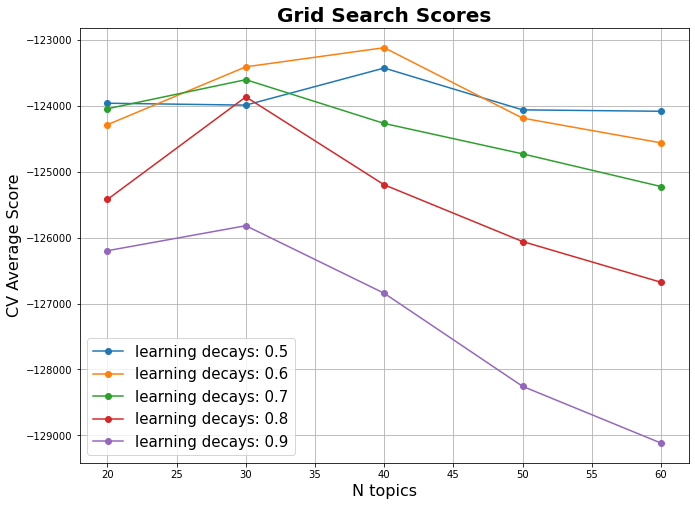

In [29]:
n_topics = [20, 30, 40, 50, 60]
n_learning_decays = [.5, .6, .7, .8, .9]
search_params = {'n_components': n_topics, 'learning_decay': n_learning_decays}
lda = LatentDirichletAllocation(
    max_iter=50, 
    learning_method='online', 
    random_state=123, 
    batch_size=250, 
    learning_offset=50.,
    evaluate_every = -1,
    n_jobs = -1 )
model = GridSearchCV(lda, param_grid=search_params)
model.fit(cv_Content)
best_lda_model = model.best_estimator_
print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(cv_Content))
fn.plot_grid_search(model.cv_results_, n_topics, n_learning_decays, 'N topics', 'learning decays')

Afficher le tag dominant de chaque question: 

In [30]:
### Create Document - Topic Matrix
lda_output = best_lda_model.transform(cv_Content)

# column names
topicnames = ["Topic " + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Question " + str(i) for i in range(len(df_ultra_major))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

#topic_size = df_document_topic.shape[1]
# Get dominant topic for each document
dominant_topic_1 = df_document_topic.values.argsort(1)[:, -1]
dominant_topic_2 = df_document_topic.values.argsort(1)[:, -2]
dominant_topic_3 = df_document_topic.values.argsort(1)[:, -3]

df_document_topic['dominant_topic_1'] = dominant_topic_1
df_document_topic['dominant_topic_2'] = dominant_topic_2
df_document_topic['dominant_topic_3'] = dominant_topic_3

# Styling
def color_green(val):
    color = 'green' if float(val) > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if float(val) > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

colums_to_show = ['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4',  'Topic 35', 'Topic 36', 'Topic 37', 'Topic 38', 'Topic 39', 'dominant_topic_1', 'dominant_topic_2', 'dominant_topic_3' ]
# Apply Style
display(df_document_topic[colums_to_show].head(15).style.applymap(color_green).applymap(make_bold))

Répartition des questions par topic:

In [31]:
df_topic_distribution = df_document_topic['dominant_topic_1'].value_counts().reset_index(name="Topic Questions")
df_topic_distribution.columns = ['Topic Num', 'Num Questions']
display(df_topic_distribution)

Topic Num  Num Questions
0          19            537
1          32            343
2          27            271
3          29            264
4          20            246
5          28            246
6          30            219
7          33            204
8          31            196
9          36            191
10          2            186
11         17            186
12         16            175
13         23            162
14          4            149
15         13            139
16         34            122
17         21            121
18          0            118
19         11            117
20         14            114
21         38            112
22         25            112
23          8            104
24         18            102
25         12             98
26          9             96
27         35             86
28          5             84
29         24             78
30          7             77
31         10             73
32          6             70
33         37             69
34          3             68
35         26             67
36         22             60
37         15             50
38         39             41
39          1             34

In [32]:
plt.figure(figsize=(16,8))
# make barplot
sns.barplot(x='Topic Num', y="Num Questions", data=df_topic_distribution , order=df_topic_distribution['Topic Num'])
plt.title("Répartition des tags par question", size=18)
plt.tight_layout()

Visualisation du LDA avec pyLDAvis:

In [33]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, cv_Content, countvectorizer, mds='tsne')
display(panel)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
19     102.967453   58.238914       1        1  6.850167
28     -61.010429   55.195274       2        1  4.089762
20     107.097733   92.250557       3        1  3.896918
27      31.726900   94.871719       4        1  3.850662
16      19.837864   57.777840       5        1  3.800666
32     -23.959764   50.983757       6        1  3.653457
29       7.338737   -0.943273       7        1  3.560805
31    -132.524033  -46.440811       8        1  3.170009
11     -13.164747  -60.896492       9        1  3.154155
36     -12.922886   86.298149      10        1  2.916235
33      15.554400  -31.649603      11        1  2.853919
24     -39.195786  -77.788277      12        1  2.787163
13      77.556038  121.167046      13        1  2.764932
30      74.709488   17.102991      14        1  2.711075
25     -99.073761   66.966423      15        1  2.703602
7       33.181171   24.671412      16        1  2.633120
0      -89.296715   24.000977      17        1  2.631414
12     -87.946449  -17.281017      18        1  2.538501
5      -82.780724 -102.124825      19        1  2.458578
23      20.788605  140.731094      20        1  2.439322
21     -48.360283   26.056973      21        1  2.424389
34     -50.977688   -9.066432      22        1  2.361956
35     -95.344215  104.972115      23        1  2.286359
4      -50.419849  -38.944828      24        1  2.277584
9      117.007690  -57.966614      25        1  2.187973
2      -25.488428  129.593094      26        1  2.004723
8      -46.540791   87.082138      27        1  1.987266
6       69.042488  -32.515179      28        1  1.937853
18     113.024391   -2.826853      29        1  1.840762
26      29.485245  -65.709549      30        1  1.834174
3       33.641327 -121.977470      31        1  1.826739
17      42.448254   -5.092345      32        1  1.759638
22     -85.504395  -56.877457      33        1  1.652818
38     -19.476011  -22.245287      34        1  1.577322
39      68.983246  -76.945213      35        1  1.544717
14      -1.254090   28.014219      36        1  1.415485
10     -15.945604 -111.448318      37        1  1.223366
1      -19.233809   11.848860      38        1  1.061117
15      58.488213   55.782330      39        1  0.715359
37    -126.238693    2.077903      40        1  0.615938, topic_info=      Term         Freq        Total Category  logprob  loglift
5        c  5228.000000  5228.000000  Default  30.0000  30.0000
87     use  5329.000000  5329.000000  Default  29.0000  29.0000
63  python  4491.000000  4491.000000  Default  28.0000  28.0000
78  string  3472.000000  3472.000000  Default  27.0000  27.0000
26    file  3445.000000  3445.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
44    look     0.031483   855.826044  Topic40 -10.2859  -5.1206
88    user     0.031483   897.333697  Topic40 -10.2859  -5.1680
27    find     0.031483  1605.328411  Topic40 -10.2859  -5.7496
51    need     0.031483  1207.484572  Topic40 -10.2859  -5.4648
54  object     0.031483  1936.478260  Topic40 -10.2859  -5.9372

[1895 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0        40  0.998128   .net
1        25  0.998859      a
2        16  0.957962    add
2        32  0.040976    add
3        37  0.999665  array
...     ...       ...    ...
98        8  0.056139  write
98       14  0.027609  write
98       17  0.837486  write
98       24  0.070864  write
99        8  0.999556      x

[409 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 29, 21, 28, 17, 33, 30, 32, 12, 37, 34, 25, 14, 31, 26, 8, 1, 13, 6, 24, 22, 35, 36, 5, 10, 3, 9, 7, 19, 27, 4, 18, 23, 39, 40, 15, 11, 2, 16, 38])

On peut essayer de visualiser les questions par groupes de tag associés.

In [40]:
# Construct the k-means clusters
clusters = KMeans(n_clusters=40, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 40 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.15  0.05  0.13  0.09  0.13  0.18  0.1   0.15  0.08  0.1   0.05  0.19
   0.13  0.13  0.08  0.04  0.26  0.1   0.1   0.41  0.2   0.17  0.08  0.14
   0.15  0.13  0.11  0.28  0.2   0.2   0.14  0.2   0.27  0.14  0.15  0.11
   0.13  0.04  0.08  0.08]
 [-0.06 -0.02 -0.1   0.02 -0.07 -0.04 -0.03 -0.06 -0.05 -0.    0.01 -0.12
  -0.03 -0.05 -0.04 -0.01 -0.14 -0.1  -0.02  0.81  0.04 -0.06 -0.05 -0.03
  -0.09  0.04 -0.06  0.02 -0.02 -0.06 -0.12  0.04 -0.44 -0.09 -0.09 -0.03
   0.05 -0.02 -0.03 -0.02]]
Perc of Variance Explained: 
 [0.01 0.08]


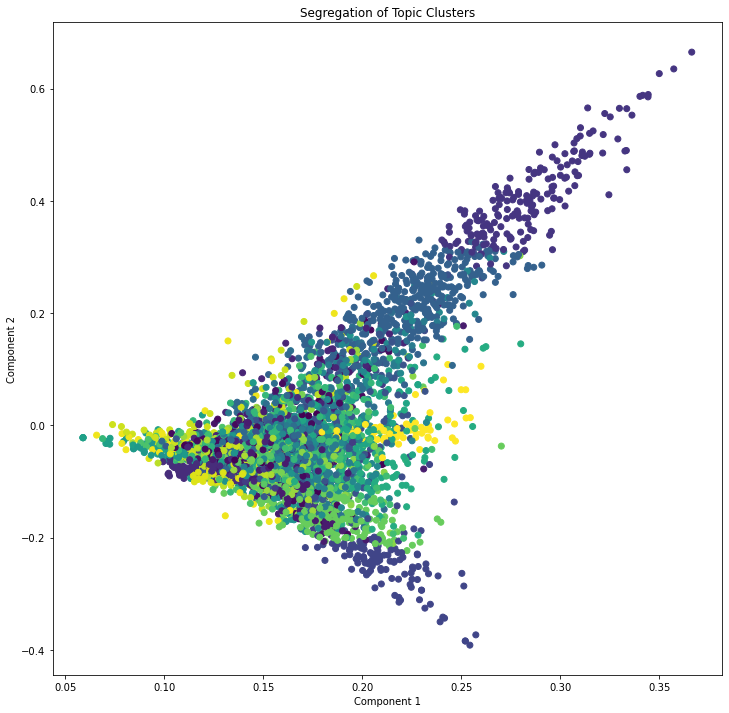

In [41]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )
plt.show()

Visionner les mots clefs des topics

In [34]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = countvectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
display(df_topic_keywords.head())

.net      a    add  array      b      c    c++   call   case  \
Topic 0  0.025  0.025  0.025  0.025  0.025  0.025  0.025  0.025  0.025   
Topic 1  0.025  0.025  0.025  0.025  0.025  0.025  0.025  0.025  0.025   
Topic 2  0.025  0.025  0.025  0.025  0.025  0.025  0.025  0.025  0.025   
Topic 3  0.025  0.025  0.025  0.025  0.025  0.025  0.025  0.025  0.025   
Topic 4  0.025  0.025  0.025  0.025  0.025  0.025  0.025  0.025  0.025   

         change  ...  variable   void       want       way    without   word  \
Topic 0   0.025  ...     0.025  0.025  49.156913  0.025000   0.025002  0.025   
Topic 1   0.025  ...     0.025  0.025   0.025000  0.025000   0.025000  0.025   
Topic 2   0.025  ...     0.025  0.025  61.595342  0.025000   0.025000  0.025   
Topic 3   0.025  ...     0.025  0.025   0.025000  0.025000   0.025000  0.025   
Topic 4   0.025  ...     0.025  0.025  37.768602  0.025005  46.959692  0.025   

          work      would       write      x  
Topic 0  0.025   0.025000  925.430216  0.025  
Topic 1  0.025   0.025000    0.025025  0.025  
Topic 2  0.025   0.025000    0.025000  0.025  
Topic 3  0.025   0.025000    0.030513  0.025  
Topic 4  0.025  90.816096   71.303749  0.025  

[5 rows x 100 columns]

In [35]:
topic_keywords = fn.show_topics(countvectorizer, best_lda_model, 15) 

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
display(df_topic_keywords.head())

Word 0   Word 1    Word 2    Word 3  Word 4 Word 5   Word 6   Word 7  \
Topic 0   code    write       see      know     try   want  example     look   
Topic 1   line   follow      read  question   write  thank     code      see   
Topic 2    php    thank      want   example     try   know   follow     like   
Topic 3   type  program       try     write  follow    use      run      way   
Topic 4   read    learn  question      good    know    one     like  program   

          Word 8 Word 9   Word 10    Word 11 Word 12    Word 13  Word 14  
Topic 0  problem   need      like  something    read        one     make  
Topic 1      add  would       one        new    look    problem     give  
Topic 2  problem    get  possible       code     use  duplicate     look  
Topic 3     like   know     first          c    void       main     look  
Topic 4    would   look     write       give     see      thank  without

sauvegarde du meilleur model:

In [36]:
joblib.dump(best_lda_model, 'best_lda_model.jl')
joblib.dump(countvectorizer, 'lda_countvectorizer.jl')
# then reload it with
# best_lda_model = joblib.load('best_lda_model.jl')
# countvectorizer = joblib.load('lda_countvectorizer.jl')

['lda_countvectorizer.jl']

Pour tenter de prédire des mots clefs on pourrait prendre les trois mots les plus forts du topic dominant, les deux mots les plus forts du second topic dominant et le mot le plus fort du troisième topic dominant.

In [37]:
lda_predicted_tag = []
for index, row in df_document_topic.iterrows():
    lda_predicted_tag.append(" ".join(np.unique(np.concatenate(([w for w in df_topic_keywords.iloc[int(row['dominant_topic_1'])][:3]],
                           [w for w in df_topic_keywords.iloc[int(row['dominant_topic_2'])][:2]],
                           [w for w in df_topic_keywords.iloc[int(row['dominant_topic_3'])][:1]])))))
df_document_topic['predicted_tag'] = lda_predicted_tag
columns_dominant_topics = ['dominant_topic_1', 'dominant_topic_2', 'dominant_topic_3', 'predicted_tag' ]
display(df_document_topic[columns_dominant_topics])

dominant_topic_1  dominant_topic_2  dominant_topic_3  \
Question 0                   16                31                29   
Question 1                   13                21                 3   
Question 2                    4                14                39   
Question 3                   13                34                 4   
Question 4                   24                 4                39   
...                         ...               ...               ...   
Question 5782                23                16                19   
Question 5783                20                25                30   
Question 5784                17                24                34   
Question 5785                 2                11                16   
Question 5786                16                36                18   

                                        predicted_tag  
Question 0                  c++ know need use value x  
Question 1     difference get name object return type  
Question 2          call follow learn question r read  
Question 3          find good name object read return  
Question 4             call learn make read set would  
...                                               ...  
Question 5782        example give int need string use  
Question 5783           file function i main n return  
Question 5784              change find git make would  
Question 5785            like php thank use user want  
Question 5786     class know need public use variable  

[5787 rows x 4 columns]

In [63]:
if not data_already_filtered:
    df_ultra_major['BestLdaEstimatedUltraTags'] = lda_predicted_tag
    df_ultra_major['BestLdaEstimatedUltraTagsScore']  = df_ultra_major['Tags'].combine(df_ultra_major['BestLdaEstimatedUltraTags'], func=fn.tags_scoring)                                                                         
    df_ultra_major.to_csv('df_ultra_major.csv', index=False)
else:
    df_ultra_major = pd.read_csv('df_ultra_major.csv')
display(df_ultra_major[['Tags', 'BestLdaEstimatedUltraTags', 'BestLdaEstimatedUltraTagsScore' ]].head(15))   
print('Moyenne final de détection des tags de la méthode LDA: {}'.format(df_ultra_major['BestLdaEstimatedUltraTagsScore' ].mean()))

Tags               BestLdaEstimatedUltraTags  \
0    c++ regex                c++ know need use value x   
1      c# .net   difference get name object return type   
2        regex        call follow learn question r read   
3          oop        find good name object read return   
4          wpf           call learn make read set would   
5         .net            .net know learn like read see   
6          oop         int learn name question read std   
7           c#     c code duplicate mean possible write   
8          php            call like php thank user want   
9   php python          method new one print python try   
10       regex          make name text value word would   
11     c# .net        learn like new question read user   
12     c# .net           .net know learn read see would   
13    .net wpf            .net c find good know problem   
14      python         find learn print python read try   

    BestLdaEstimatedUltraTagsScore  
0                             50.0  
1                              0.0  
2                              0.0  
3                              0.0  
4                              0.0  
5                            100.0  
6                              0.0  
7                              0.0  
8                            100.0  
9                             50.0  
10                             0.0  
11                             0.0  
12                            50.0  
13                            50.0  
14                           100.0

Moyenne final de détection des tags de la méthode LDA: 38.155924197914885


Le score de notre LDA est vraiment convenable du fait de la méthode que j'ai mis en place en scorant sur les 3 topics majeurs des textes et en retenant un nombre de mots clés dégressif en fonction de l'importance du topic. Essayons maintenant de prédire un tag avec du texte.

In [39]:
# Predict the topic
mytext = """easy - - use regular expression support c++ ? look robust , easy - - use , regular expression evaluator native c++ , either platform - independent windows - specific . 
 requirement : 

 use boost ace regex library ( unfortunately ) 
 use .net regex ( manage code ) 

 main requirement standalone open . """


mytext_predicted_tags = fn.predict_with_lda(mytext, df_stop_words.values, countvectorizer, best_lda_model)
print(mytext_predicted_tags)

check text use value variable word


On pourrait ainsi obtenir les questions similaires à un texte donné, celles ayant les mêmes tags. Pour cela on pourrait utiliser la distance euclidienne.

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#21howtogetsimilardocumentsforagivendocument

Ou aurait aussi probablement pu améliorer la précisision en utilisant des bigrams et des trigrams.

## modélisation supervisée

In [42]:
display(df_words_count)

words   count
0                    use  105730
1                   code   50968
2                   like   49619
3                   file   48808
4                    get   48052
...                  ...     ...
215265      holosericeus       1
215266        agelaioide       1
215267  programattically       1
215268              d422       1
215269              cb93       1

[215270 rows x 2 columns]

In [44]:
tfidf = TfidfVectorizer(tokenizer=fn.tokenize, stop_words=sw)
tfidf_questions = tfidf.fit_transform(df_ultra_major['WeightedContent'].values)
df_tfidfvect_questions = pd.DataFrame(data = tfidf_questions.toarray(),columns = tfidf.get_feature_names())
display(df_tfidfvect_questions)

.a  .a1  .a2  .a3  .a89  .aaronstannard  .abc  .abcd  .abspath  .ac  \
0     0.0  0.0  0.0  0.0   0.0             0.0   0.0    0.0       0.0  0.0   
1     0.0  0.0  0.0  0.0   0.0             0.0   0.0    0.0       0.0  0.0   
2     0.0  0.0  0.0  0.0   0.0             0.0   0.0    0.0       0.0  0.0   
3     0.0  0.0  0.0  0.0   0.0             0.0   0.0    0.0       0.0  0.0   
4     0.0  0.0  0.0  0.0   0.0             0.0   0.0    0.0       0.0  0.0   
...   ...  ...  ...  ...   ...             ...   ...    ...       ...  ...   
5782  0.0  0.0  0.0  0.0   0.0             0.0   0.0    0.0       0.0  0.0   
5783  0.0  0.0  0.0  0.0   0.0             0.0   0.0    0.0       0.0  0.0   
5784  0.0  0.0  0.0  0.0   0.0             0.0   0.0    0.0       0.0  0.0   
5785  0.0  0.0  0.0  0.0   0.0             0.0   0.0    0.0       0.0  0.0   
5786  0.0  0.0  0.0  0.0   0.0             0.0   0.0    0.0       0.0  0.0   

      ...  zur  zurb  zwr  zwrite  zxcv   zz  zzz  zzzzzz  zzzzzzwtf  \
0     ...  0.0   0.0  0.0     0.0   0.0  0.0  0.0     0.0        0.0   
1     ...  0.0   0.0  0.0     0.0   0.0  0.0  0.0     0.0        0.0   
2     ...  0.0   0.0  0.0     0.0   0.0  0.0  0.0     0.0        0.0   
3     ...  0.0   0.0  0.0     0.0   0.0  0.0  0.0     0.0        0.0   
4     ...  0.0   0.0  0.0     0.0   0.0  0.0  0.0     0.0        0.0   
...   ...  ...   ...  ...     ...   ...  ...  ...     ...        ...   
5782  ...  0.0   0.0  0.0     0.0   0.0  0.0  0.0     0.0        0.0   
5783  ...  0.0   0.0  0.0     0.0   0.0  0.0  0.0     0.0        0.0   
5784  ...  0.0   0.0  0.0     0.0   0.0  0.0  0.0     0.0        0.0   
5785  ...  0.0   0.0  0.0     0.0   0.0  0.0  0.0     0.0        0.0   
5786  ...  0.0   0.0  0.0     0.0   0.0  0.0  0.0     0.0        0.0   

      zzzzzzzzz  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
...         ...  
5782        0.0  
5783        0.0  
5784        0.0  
5785        0.0  
5786        0.0  

[5787 rows x 18471 columns]

Même en utilisant une PCA, 18470 me parait un nombre de colonnes beaucoup trop grand pour pouvoir traiter le problème. On va enlever les mots qui ne sont pas représentatifs, c'est à dire les mots qui ont une occurrence d'apparition inférieure à celle du tag le moins utilisé.

In [45]:
countvectorizer = CountVectorizer(tokenizer=fn.tokenize, analyzer='word')
cv_tags = countvectorizer.fit_transform(df_ultra_major['Tags'])
df_countvect_tags = pd.DataFrame(data = cv_tags.toarray(),columns = countvectorizer.get_feature_names())
display(df_countvect_tags)

.net  .x  angular  c  c#  c++  git  linux  oop  php  python  r  regex  \
0        0   0        0  0   0    1    0      0    0    0       0  0      1   
1        1   0        0  0   1    0    0      0    0    0       0  0      0   
2        0   0        0  0   0    0    0      0    0    0       0  0      1   
3        0   0        0  0   0    0    0      0    1    0       0  0      0   
4        0   0        0  0   0    0    0      0    0    0       0  0      0   
...    ...  ..      ... ..  ..  ...  ...    ...  ...  ...     ... ..    ...   
5782     0   0        0  0   1    0    0      0    0    0       0  0      0   
5783     0   0        0  0   0    0    0      1    0    0       0  0      0   
5784     0   0        0  0   0    0    1      0    0    0       0  0      0   
5785     0   0        0  0   0    0    0      0    0    1       0  0      0   
5786     0   0        0  0   0    1    0      0    0    0       0  0      0   

      wpf  
0       0  
1       0  
2       0  
3       0  
4       1  
...   ...  
5782    0  
5783    0  
5784    0  
5785    0  
5786    0  

[5787 rows x 14 columns]

In [46]:
min_sum=math.inf
for column in df_countvect_tags:
    col_sum = df_countvect_tags[column].sum();
    if(col_sum < min_sum):
        min_sum = col_sum
    print('column {}, count = {}'.format(column, col_sum))
print("=================================================")
print("occurences du tag le moins présent: ", min_sum)

column .net, count = 321
column .x, count = 260
column angular, count = 63
column c, count = 624
column c#, count = 1012
column c++, count = 1102
column git, count = 252
column linux, count = 136
column oop, count = 152
column php, count = 845
column python, count = 1898
column r, count = 447
column regex, count = 310
column wpf, count = 78
occurences du tag le moins présent:  63


In [47]:
ultra_content_words_tokenized = []
for content in df_ultra_major['Content'].values:
    ultra_content_words_tokenized.append(fn.tokenize(content.lower()))
#display(content_words_tokenized)
freq = dict()
i=0
for words in ultra_content_words_tokenized:
    freq[i] = fq = nltk.FreqDist(words)
    i += 1 
# on récupère la fréquence totale de chaque tag
freq_words = nltk.Counter()
for i in range(0,len(ultra_content_words_tokenized)):
    freq_words += freq[i]
#for item, count in freq_words.most_common():
#    print ('{} -> {}'.format(item,count))
ultra_words_count = []
for item, count in freq_words.most_common():
    ultra_words_count.append([ item, count])
df_ultra_words_count = pd.DataFrame(data=ultra_words_count, columns=["words", "count"])

In [64]:
display(df_ultra_words_count[df_ultra_words_count['count']<min_sum].shape)

(18044, 2)

Cette réduction manuelle nous enlèvera 97% des colonnes et nous permettra donc de résoudre notre problématique.

In [49]:
df_ultra_unrepresentative_worlds = df_ultra_words_count[df_ultra_words_count['count']<min_sum]
display(df_ultra_unrepresentative_worlds)

words  count
869             exact     62
870             guide     62
871    initialization     62
872            inline     62
873           prevent     62
...               ...    ...
18908          resign      1
18909             wsl      1
18910      powershell      1
18911     freelance12      1
18912           lamda      1

[18044 rows x 2 columns]

In [50]:
sw.update(df_ultra_unrepresentative_worlds['words'].values)

df_stop_words = pd.DataFrame(data=sw, columns=["stop-words"])
df_stop_words.to_csv('stop-words.csv', index=False)
display(df_stop_words)


stop-words
0             NaN
1             uff
2      arrayjson1
3          dblink
4          beside
...           ...
18444  arithmetic
18445   maternity
18446        trac
18447         jam
18448         log

[18449 rows x 1 columns]

In [51]:
tfidf = TfidfVectorizer(tokenizer=fn.tokenize, stop_words=sw)
tfidf_questions = tfidf.fit_transform(df_ultra_major['Content'].values)
df_tfidfvect_questions = pd.DataFrame(data = tfidf_questions.toarray(),columns = tfidf.get_feature_names())

In [52]:
display(df_tfidfvect_questions)

.append   .c  .cpp   .e  .frame   .g  .get   .h  .html  .name  ...   x6  \
0         0.0  0.0   0.0  0.0     0.0  0.0   0.0  0.0    0.0    0.0  ...  0.0   
1         0.0  0.0   0.0  0.0     0.0  0.0   0.0  0.0    0.0    0.0  ...  0.0   
2         0.0  0.0   0.0  0.0     0.0  0.0   0.0  0.0    0.0    0.0  ...  0.0   
3         0.0  0.0   0.0  0.0     0.0  0.0   0.0  0.0    0.0    0.0  ...  0.0   
4         0.0  0.0   0.0  0.0     0.0  0.0   0.0  0.0    0.0    0.0  ...  0.0   
...       ...  ...   ...  ...     ...  ...   ...  ...    ...    ...  ...  ...   
5782      0.0  0.0   0.0  0.0     0.0  0.0   0.0  0.0    0.0    0.0  ...  0.0   
5783      0.0  0.0   0.0  0.0     0.0  0.0   0.0  0.0    0.0    0.0  ...  0.0   
5784      0.0  0.0   0.0  0.0     0.0  0.0   0.0  0.0    0.0    0.0  ...  0.0   
5785      0.0  0.0   0.0  0.0     0.0  0.0   0.0  0.0    0.0    0.0  ...  0.0   
5786      0.0  0.0   0.0  0.0     0.0  0.0   0.0  0.0    0.0    0.0  ...  0.0   

       xa  xc2  year  yes  yet    z  zero  zip  zone  
0     0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0  
1     0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0  
2     0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0  
3     0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0  
4     0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0  
...   ...  ...   ...  ...  ...  ...   ...  ...   ...  
5782  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0  
5783  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0  
5784  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0  
5785  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0  
5786  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0  

[5787 rows x 531 columns]

On se retrouve maintenant avec un nombre de colonne adéquat qui va nous permettre d'effectuer une PCA efficacement.

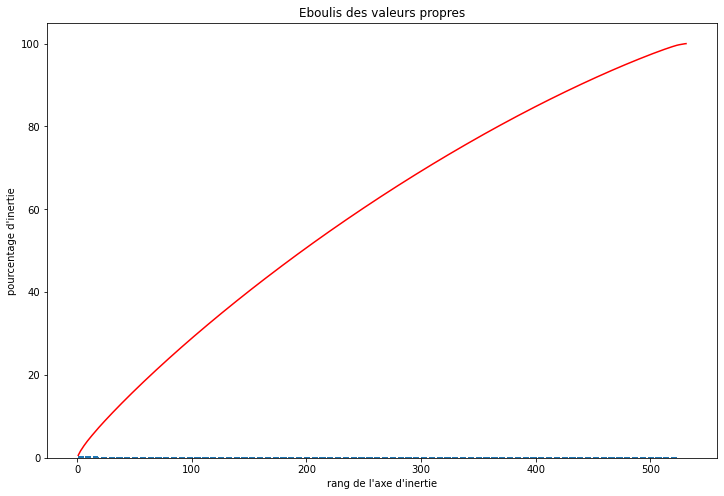

In [53]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.figure(figsize=(12, 8))
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red")
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

n_comp = 531
    
# préparation des données pour l'ACP
X = df_tfidfvect_questions.values
features = df_tfidfvect_questions.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
    
X_scaled = std_scale.transform(X)


# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

X_projected = pca.transform(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

In [54]:
np.savetxt("word_columns.txt", df_tfidfvect_questions.columns.values, delimiter=', ', fmt="%s")
word_columns = np.loadtxt("word_columns.txt", delimiter=', ', dtype=str)

Avec 370 colonnes on arrive à expliquer 80% des données, ce qui peut sembler suffisant pour obtenir une prédiction relativement stable.

In [55]:
n_comp = 370
    
# préparation des données pour l'ACP
X = df_tfidfvect_questions.values
features = df_tfidfvect_questions.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)
y = df_countvect_tags

joblib.dump(std_scale, 'StandardScaler.jl')
joblib.dump(tfidf, 'TfidfVectorizer.jl')
joblib.dump(pca, 'PCA.jl')

['PCA.jl']

In [56]:
# le gradiant boosting classifier donne des résultats moyennement correct et son exécution ets un peu lente, on l'enregistre
X_train, X_test, y_train, y_test = train_test_split(X_projected, df_ultra_major['Tags'].values, test_size=0.05)
if not data_already_filtered:
    gbc = GradientBoostingClassifier(n_estimators=50, learning_rate = 0.1, random_state=123)
    model = gbc.fit(X_train, y_train)
    joblib.dump(gbc, 'GradientBoostingClassifier.jl')
else:
    gbc = joblib.load('GradientBoostingClassifier.jl')
    
pred = gbc.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print("accuracy {:.2f}".format(accuracy))

accuracy 0.34


In [66]:
# le gradiant boosting classifier donne des résultats correct mais son exécution est un peu lente, on l'enregistre
X_train, X_test, y_train, y_test = train_test_split(X_projected, df_ultra_major['Tags'].values, test_size=0.05)
if data_already_filtered:
    rfc = RandomForestClassifier( random_state=123, n_jobs=-1) 
    rfc.fit(X_train, y_train)
    joblib.dump(rfc, 'RandomForestClassifier.jl')
else:
    rfc = joblib.load('RandomForestClassifier.jl')
    
pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print("accuracy {:.2f}".format(accuracy))

accuracy 0.42


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_projected, df_ultra_major['Tags'].values, test_size=0.05)
if not data_already_filtered:
    param_grid = { 
        'n_estimators': [100, 200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'criterion' :['gini', 'entropy']
    }

    rfc = RandomForestClassifier( random_state=123, n_jobs=-1) 
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    CV_rfc.fit(X_train, y_train)
    best_rfc=CV_rfc.best_estimator_
    joblib.dump(best_rfc, 'BestRandomForestClassifier.jl')
else:
    best_rfc = joblib.load('BestRandomForestClassifier.jl')
    
pprint(best_rfc.get_params())
pred = best_rfc.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print("accuracy {:.2f}".format(accuracy))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}
accuracy 0.39


In [59]:
pred = best_rfc.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print("accuracy {:.2f}".format(accuracy))

accuracy 0.39


In [67]:
# Predict the topic
mytext = """easy - - use regular expression support c++ ? look robust , easy - - use , regular expression evaluator native c++ , either platform - independent windows - specific . 
 requirement : 

 use boost ace regex library ( unfortunately ) 
 use .net regex ( manage code ) 

 main requirement standalone open . et beaucoup de blabla """

print(fn.predict_with_gbc_or_rfc(mytext, tfidf, word_columns, std_scale, pca, gbc))
print(fn.predict_with_gbc_or_rfc(mytext, tfidf, word_columns, std_scale, pca, best_rfc))
print(fn.predict_with_gbc_or_rfc(mytext, tfidf, word_columns, std_scale, pca, rfc))

D:\tuto\OCR\workspace\jupyter\P5\projet\functions.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tfidf_text[word] = 0
D:\tuto\OCR\workspace\jupyter\P5\projet\functions.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tfidf_text[word] = 0


c++ 
c++ 
c 


D:\tuto\OCR\workspace\jupyter\P5\projet\functions.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tfidf_text[word] = 0
